# Введение

Вы — специалист по Data Sciense в каршеринговой компании. Вам поступил заказ: нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.
Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.
Идея решения задачи от заказчика: 

    Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)
     
 - Для модели выбрать тип виновника — только машина (car).
 -        Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
 -       Для моделирования ограничиться данными за 2012 год — они самые свежие.
 -      Обязательное условие — учесть фактор возраста автомобиля.
 - На основе модели исследовать основные факторы ДТП.
 
 
  Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:
     
 - Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
 - Какие ещё факторы нужно учесть?
 - Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?

Заказчик предлагает вам поработать с базой данных по происшествиям и сформировать свои идеи создания такой системы. 

In [1]:
!pip install ydata_profiling

In [2]:
from ydata_profiling import ProfileReport

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier
import catboost
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix
pd.options.mode.chained_assignment = None
from sklearn.metrics import f1_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

## Подключитесь к базе. Загрузите таблицы sql

In [4]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

In [5]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [6]:
engine = create_engine(connection_string) 

## Проведите первичное исследование таблиц

In [7]:
query = '''
SELECT *
FROM collisions
limit 10
'''

sample_collisions = pd.read_sql_query(query, con=engine) 
sample_collisions.head()

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [8]:
query = '''
select *
from case_ids
limit 10
'''
sample_case_ids = pd.read_sql_query(query, con=engine)
sample_case_ids.head()

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


In [9]:
query = '''
SELECT *
FROM vehicles
limit 10
'''

sample_vehicles = pd.read_sql_query(query, con=engine) 
sample_vehicles.head()

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


In [10]:
query = '''
SELECT *
FROM parties
limit 10
'''

sample_parties = pd.read_sql_query(query, con=engine) 
sample_parties.head()

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0


### Вывод




   - Все таблицы имеют набор данных;
   - Количество таблиц соответствует условию задачи;
   - Общий ключ для связи таблиц имеется.



##  Проведите статистический анализ факторов ДТП

**Исследуем количество аварий в зависимости от месяца и дня недели**

In [11]:
query = '''
select distinct extract(month from collision_date) month_date,
      count(case_id) total_collisions
from collisions
where extract(year from collision_date) = 2012
group by month_date
order by total_collisions desc
'''

count_collions_by_month = pd.read_sql_query(query, con=engine)
count_collions_by_month.head(5)

,month_date,total_collisions
0,3.0,32498
1,1.0,32020
2,2.0,30377
3,4.0,29143
4,5.0,25168


In [12]:
query = '''
select distinct extract(dow from collision_date) day_of_week,
      count(case_id) total_collisions
from collisions
where collision_damage != '0 – SCRATCH'
and collision_date between '2012-01-01' and '2013-01-01'
group by day_of_week
order by total_collisions desc
'''

count_collions_by_days = pd.read_sql_query(query, con=engine)
count_collions_by_days.head(5)

,day_of_week,total_collisions
0,5.0,25187
1,3.0,23259
2,4.0,22863
3,2.0,22796
4,1.0,21335


In [13]:
query = '''
select distinct intersection,
       count(case_id) count_collisions
from collisions
where collision_date between '2012-01-01' and '2013-01-01'
group by intersection
order by count_collisions desc
'''

intersection_damage = pd.read_sql_query(query, con=engine)
intersection_damage

,intersection,count_collisions
0,0.0,120558
1,1.0,33083
2,NaN,910


In [14]:
query = '''
select distinct road_surface,
       count(collision_damage) over (partition by road_surface) count_collision_damage       
from collisions
where collision_damage != '0 – SCRATCH'
and collision_date between '2012-01-01' and '2013-01-01'
'''
damage_collisions = pd.read_sql_query(query, con=engine)
damage_collisions

,road_surface,count_collision_damage
0,dry,136494
1,snowy,845
2,wet,15894
3,slippery,138
4,None,1180


In [15]:
query = '''
select distinct road_condition_1,
       count(collision_damage) over (partition by road_condition_1) count_road_condition       
from collisions
where road_condition_1 != 'normal' 
and collision_damage != '0 – SCRATCH'
and collision_date between '2012-01-01' and '2013-01-01'
order by count_road_condition desc
'''
road_condition = pd.read_sql_query(query, con=engine)
road_condition.head(5)

,road_condition_1,count_road_condition
0,construction,2250
1,other,663
2,holes,595
3,obstruction,592
4,loose material,294


In [16]:
query = '''
select distinct primary_collision_factor,
       count(primary_collision_factor) count_collision_factor
from collisions
where primary_collision_factor != 'unknown' 
and collision_date between '2012-01-01' and '2013-01-01'
group by primary_collision_factor
order by count_collision_factor desc
'''
collisions_reasons = pd.read_sql_query(query, con=engine)
collisions_reasons

,primary_collision_factor,count_collision_factor
0,vehicle code violation,145804
1,other than driver,3324
2,other improper driving,862
3,fell asleep,7


In [17]:
query = '''
select distinct pcf_violation_category,
       count(pcf_violation_category) count_pcf_violation_category
from collisions
where collision_date between '2012-01-01' and '2013-01-01'
group by pcf_violation_category
order by count_pcf_violation_category desc
limit 5
'''
violation_category = pd.read_sql_query(query, con=engine)
violation_category

,pcf_violation_category,count_pcf_violation_category
0,speeding,49515
1,improper turning,26453
2,automobile right of way,16752
3,dui,12274
4,unsafe lane change,10686


In [18]:
query = '''
select distinct weather_1,
       count(case_id) count_collisions
from collisions
where collision_date between '2012-01-01' and '2013-01-01'
group by weather_1
order by count_collisions desc
'''
weather_damage = pd.read_sql_query(query, con=engine)
weather_damage

,weather_1,count_collisions
0,clear,122592
1,cloudy,23372
2,raining,6938
3,None,551
4,fog,515
5,snowing,368
6,other,169
7,wind,46


In [19]:
query = '''
select distinct lighting,
       count(case_id) count_collisions
from collisions
where collision_date between '2012-01-01' and '2013-01-01'
group by lighting
order by count_collisions desc
'''
lighting_damage = pd.read_sql_query(query, con=engine)
lighting_damage

,lighting,count_collisions
0,daylight,103402
1,dark with street lights,32715
2,dark with no street lights,12123
3,dusk or dawn,5283
4,None,665
5,dark with street lights not functioning,363


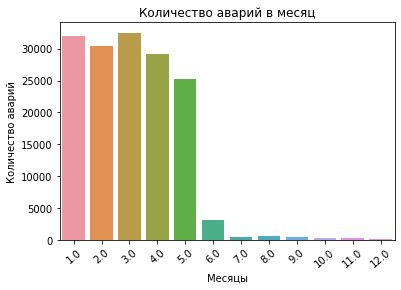

In [20]:
sns.barplot(data = count_collions_by_month, x='month_date', y='total_collisions')
plt.title('Количество аварий в месяц')
plt.xticks(rotation=40)
plt.xlabel('Месяцы')
plt.ylabel('Количество аварий')
plt.show()

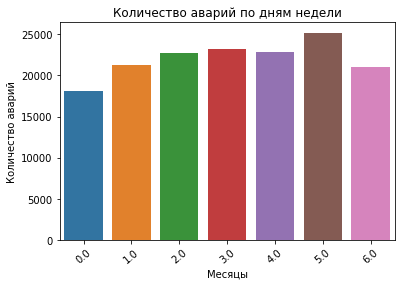

In [21]:
sns.barplot(data = count_collions_by_days, x='day_of_week', y='total_collisions')
plt.title('Количество аварий по дням недели')
plt.xticks(rotation=40)
plt.xlabel('Месяцы')
plt.ylabel('Количество аварий')
plt.show()

Как видно из графиков, наибольшее количество аварий приходится на субботу, наименьшее - воскресенье. В течении рабочей недели количество аварий является постоянным    
Пятница это конец рабочей недели, большая активность в городах, возможны нетрезвые водители. Учитывая, что датасет собран за 2012 год, уровень ответственности граждан был еще меньше чем сейчас :)

2012 год не является самым репрезентативным, так как во 2 половине года у нас нет данных по авариям

Я бы предложил заказчику разширить диапазон сбора данных до полного диапазона, так как для лета осени и начала зимы мы не располагаем какой либо информацией для анализа


**Добавлено**

In [22]:
query = '''
select distinct extract(month from collision_date) month_date,
      count(case_id) total_collisions
from collisions
group by month_date
order by total_collisions desc
'''

count_collions_by_month_all = pd.read_sql_query(query, con=engine)
count_collions_by_month_all.head(5)

,month_date,total_collisions
0,3.0,139581
1,1.0,132044
2,5.0,130316
3,4.0,130180
4,2.0,128858


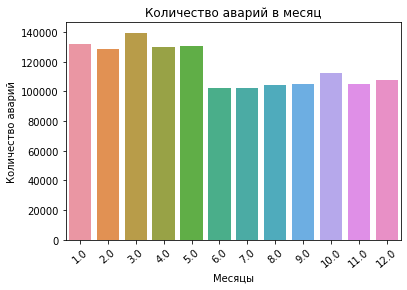

In [23]:
sns.barplot(data = count_collions_by_month_all, x='month_date', y='total_collisions')
plt.title('Количество аварий в месяц')
plt.xticks(rotation=40)
plt.xlabel('Месяцы')
plt.ylabel('Количество аварий')
plt.show()

**кажется, что саммари наибольшее количество аварий в марте(сезон замены покрышек у автолюбителей)**  
**картина с июня по декабрь не дает нам правдивых показателей, так как 2012 год у нас запорлнен лишь наполовину**

Проведем анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП:

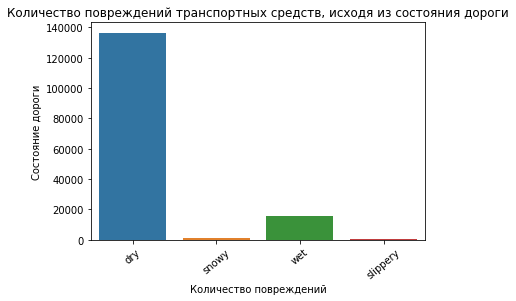

In [24]:
sns.barplot(data = damage_collisions, x='road_surface', y='count_collision_damage')
plt.title('Количество повреждений транспортных средств, исходя из состояния дороги')
plt.xticks(rotation=40)
plt.xlabel('Количество повреждений')
plt.ylabel('Состояние дороги')
plt.show()

Очевидно, что чаще всего дтп происходят когда дорогая сухая, можем предположить, что общее количество дождливых дней было небольшим так же можно увидеть что мокрая дорога может повлиять на вероятность возникновения ДТП

Проведем анализ серьёзности повреждений транспортного средства, исходя из дорожного состояния в момент ДТП:


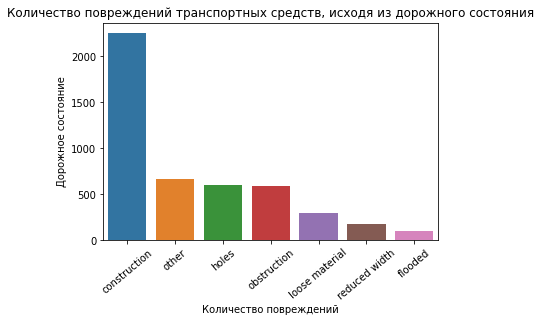

In [25]:
sns.barplot(data = road_condition, x='road_condition_1', y='count_road_condition')
plt.title('Количество повреждений транспортных средств, исходя из дорожного состояния')
plt.xticks(rotation=40)
plt.xlabel('Количество повреждений')
plt.ylabel('Дорожное состояние')
plt.show()

Вывод: качество дорог оставляет желать лучшего. преимущественно аварии происходят на дорогах в состоянии ремонта

Найдем самые частые причины ДТП (таблица parties):

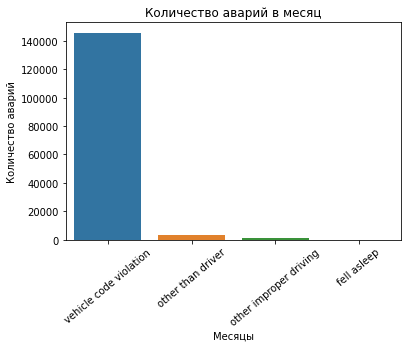

In [26]:
sns.barplot(data = collisions_reasons, x='primary_collision_factor', y='count_collision_factor')
plt.title('Количество аварий в месяц')
plt.xticks(rotation=40)
plt.xlabel('Месяцы')
plt.ylabel('Количество аварий')
plt.show()

самой частой причиной аварий является нарушение пдд

Найдем самые частые нарушения:


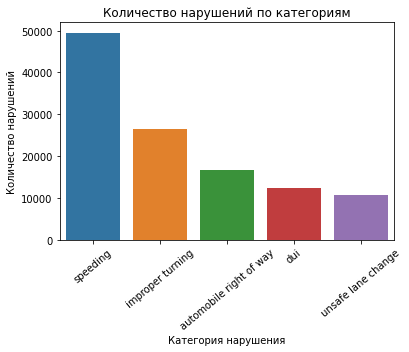

In [27]:
sns.barplot(data = violation_category, x='pcf_violation_category', y='count_pcf_violation_category')
plt.title('Количество нарушений по категориям')
plt.xticks(rotation=40)
plt.xlabel('Категория нарушения')
plt.ylabel('Количество нарушений')
plt.show()



Самыми частыми нарушениями является привышение скорости. На втором месте находится неправильный поворот

Посмотрим влияет ли погода на веротятность ДТП:


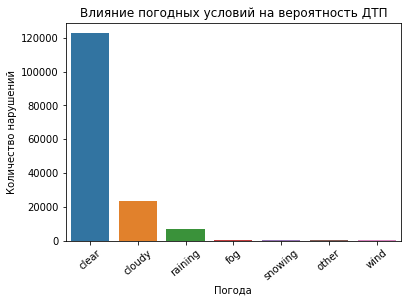

In [28]:
sns.barplot(data = weather_damage, x='weather_1', y='count_collisions')
plt.title('Влияние погодных условий на вероятность ДТП')
plt.xticks(rotation=40)
plt.xlabel('Погода')
plt.ylabel('Количество нарушений')
plt.show()



Чаще всего дтп происходят в нормальную погоду, но все же наиболее высокий риск попасть в дтп в облачную погоду или в дождь

Проверим влияет ли освещение на вероятность возникновения ДТП:


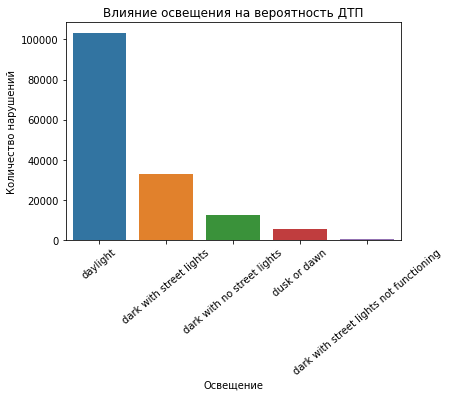

In [29]:
sns.barplot(data = lighting_damage, x='lighting', y='count_collisions')
plt.title('Влияние освещения на вероятность ДТП')
plt.xticks(rotation=40)
plt.xlabel('Освещение')
plt.ylabel('Количество нарушений')
plt.show()

Можно сделать вывод, что освещение не особо влияет на вероятность возникновения дтп, так как количество авто в течении дня вечером и ночью в целом сильно разнится. Трафик днем гораздо выше от того и количество аварий больше

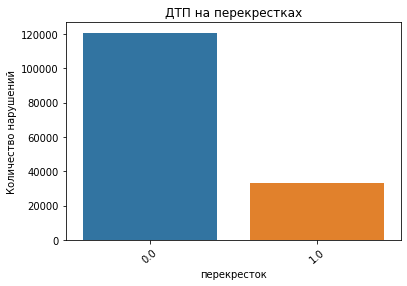

In [30]:
sns.barplot(data = intersection_damage, x='intersection', y='count_collisions')
plt.title('ДТП на перекрестках')
plt.xticks(rotation=40)
plt.xlabel('перекресток')
plt.ylabel('Количество нарушений')
plt.show()


**Вывод**

   - наибольшее количество аварий приходится на март
   - чаще всего дтп происходят когда дорогая сухая,но так же можно увидеть что мокрая дорога может повлиять на вероятность возникновения ДТП
   - ДТП чаще всего случаются на дорогах без повреждений. Однако, дороги с зоной строительства или ремонта так же увлечивают риск возникновения ДТП
   - самой частой причиной аварий является нарушение пдд
   - чаще всего дтп происходят в нормальную погоду, но все же наиболее высокий риск попасть в дтп в облачную погоду или в дождь
   - самыми частыми нарушениями является привышение скорости. На втором месте находится неправильный поворот
   - освещение не особо влияет на вероятность возникновения дтп, хотя при ночном освещении риск все же есть



In [31]:
query = '''
select distinct c.primary_collision_factor as factors,
       sum(p.at_fault) as party_type
from collisions c join parties p on c.case_id=p.case_id
where extract(year from collision_date) = 2012
group by factors
order by factors desc
'''

party_type_dmg_guilty = pd.read_sql_query(query, con=engine)
party_type_dmg_guilty

,factors,party_type
0,None,0
1,vehicle code violation,142901
2,unknown,0
3,other than driver,0
4,other improper driving,714
5,fell asleep,3


In [32]:
query = '''
select distinct c.primary_collision_factor as factors,
       count(p.at_fault) - sum(p.at_fault) as party_type
from collisions c join parties p on c.case_id=p.case_id
where extract(year from collision_date) = 2012
group by factors
order by factors desc
'''

party_type_dmg_notguilty = pd.read_sql_query(query, con=engine)
party_type_dmg_notguilty

,factors,party_type
0,None,1334
1,vehicle code violation,145913
2,unknown,7426
3,other than driver,4549
4,other improper driving,859
5,fell asleep,9


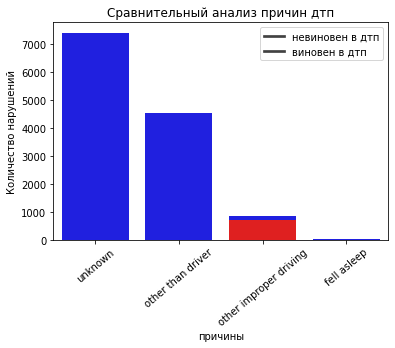

In [33]:
#Сравним причины возникновения дтп в зависимости от того был ли виновен водитель в его возникновении
#Отбросим столбец нарушение правил дтп, так как он превалирует в обоих категориях

fig, ax = plt.subplots()
sns.barplot(x='factors', y='party_type', data=party_type_dmg_notguilty.drop(index=1), ax=ax, color='b')
sns.barplot(x='factors', y='party_type', data=party_type_dmg_guilty.drop(index=1), ax=ax, color='r')
ax.legend(['невиновен в дтп', 'виновен в дтп'])
plt.title('Сравнительный анализ причин дтп')
plt.xticks(rotation=40)
plt.xlabel('причины')
plt.ylabel('Количество нарушений')
plt.show()

Как видно из графика, малая толика оставшихся причин в обоих случаях приходится на другие нарушения.
У водителей, невиновных в ДТП причина неизвестна, либо не связана с водителем (возможно какая либо неисправность или проблемы с дорожным покрытием)

In [34]:
query = '''
select distinct v.vehicle_age as age,
       count(c.COLLISION_DAMAGE) as collision_count
from collisions c join vehicles v on c.case_id=v.case_id
where extract(year from collision_date) = 2012
and c.collision_damage != 'scratch'
group by age
order by age desc
'''

collisions_by_v_age = pd.read_sql_query(query, con=engine)
collisions_by_v_age


,age,collision_count
0,NaN,1767
1,161.0,2
2,19.0,1
3,17.0,3
4,16.0,11
5,15.0,46
6,14.0,323
7,13.0,639
8,12.0,1010
9,11.0,1594


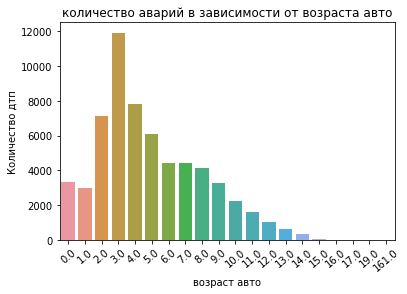

In [35]:
sns.barplot(data = collisions_by_v_age, x='age', y='collision_count')
plt.title('количество аварий в зависимости от возраста авто')
plt.xticks(rotation=40)
plt.xlabel('возраст авто')
plt.ylabel('Количество дтп')
plt.show()

Можно сделать вывод, что новые авто и авто старше 6 лет не попадают в аварии.  
Либо парк автомобилей клиента преимущественнно состоит из автомобилей возрастом 3 года

## Создайте модель для оценки водительского риска



Подготовьте набор данных на основе первичного предположения заказчика:

   - Выберите тип виновника — только машина (car). **
   - Возьмите случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина).
   - Для моделирования возьмите данные только за 2012 год.
   - Подготовка исходной таблицы должна проводиться с помощью sql-запроса.

Сразу добавим в таблицу только те факторы, которые могут влиять на вероятность дтп:


In [36]:
class DataScience:

    def path_to_files(self, path, link):
        Path('datasets').mkdir(parents=True, exist_ok=True)
        def get_file(file_name, url):
            if not os.path.exists(file_name):
                print(file_name, 'файл не найден, будет загружен из сети')
                _ = urllib.request.urlretrieve(url, file_name)
        urls = {
            'dataset': (path, link)
        }
        [get_file(*urls[k]) for k in urls]
        data = pd.read_csv(urls['dataset'][0])
        return data


    def corr_diagram(self, x):
        plt.figure(figsize=(12, 10), dpi=80)
        sns.heatmap(x.corr(), xticklabels=x.corr().columns, yticklabels=x.corr().columns, cmap='RdYlGn', center=0,
                    annot=True)
        plt.title('Диаграмма корреляции', fontsize=22)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.show()

    def clean_dataset(self, df):
        assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
        df.dropna(inplace=True)
        indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)

        return df[indices_to_keep].astype(np.float64)

    def missing_zero_values_table(self, df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
            columns={0: 'Zero Values', 1: 'Missing Values', 2: '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:, 1] != 0].sort_values(
            '% of Total Values', ascending=False).round(1)
        print("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"
                                                                                                       "There are " + str(
            mz_table.shape[0]) +
              " columns that have missing values.")

        return mz_table

       
    def fill_with_mode(self, column, column1, column2):
        df[column] = df.groupby([column1, column2])[column].transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else "Empty")))

In [37]:
ds=DataScience()

In [38]:
query = '''
with 
  p as(
        select distinct case_id,
               at_fault,
               party_type, 
               party_sobriety,
               party_drug_physical,
               cellphone_in_use
        from parties),
  c as (
        select distinct case_id,
               weather_1,
               road_surface,
               lighting,
               road_condition_1,
               collision_date,
               collision_damage,
               intersection,
               control_device
        from collisions),
  v as (
        select distinct case_id,
               vehicle_age
        from vehicles),
  c_i as (
          select distinct case_id
          from case_ids)
select p.party_type,
       p.at_fault,
       p.party_sobriety,
       p.party_drug_physical,
       c.road_surface,
       c.lighting,
       c.road_condition_1,
       v.vehicle_age,
       c.intersection,
       p.cellphone_in_use,
       c.control_device,
       c.weather_1
from c_i
join p on c_i.case_id = p.case_id
join c on c_i.case_id = c.case_id
join v on c_i.case_id = v.case_id
where party_type = 'car'
  and collision_date between '2012-01-01' and '2013-01-01'
  and collision_damage != 'scratch'
'''
df = pd.read_sql_query(query, con=engine)

In [39]:
df.head()

,party_type,at_fault,party_sobriety,party_drug_physical,road_surface,lighting,road_condition_1,vehicle_age,intersection,cellphone_in_use,control_device,weather_1
0,car,0,had not been drinking,None,dry,daylight,other,2.0,1.0,0.0,none,cloudy
1,car,1,had not been drinking,None,dry,daylight,other,2.0,1.0,0.0,none,cloudy
2,car,0,had not been drinking,None,dry,daylight,normal,5.0,1.0,0.0,none,clear
3,car,1,had not been drinking,None,dry,daylight,normal,5.0,1.0,0.0,none,clear
4,car,0,had not been drinking,None,dry,daylight,normal,1.0,1.0,0.0,functioning,clear


Были отобраны факторы, которые могут влиять на вероятность ДТП:

    'party_sobriety' - Уровень трезвости виновника (точно может влиять) Таблица parties  
    'party_drug_physical' - Состояние участника: физическое или с учётом принятых лекарств. Таблица parties  
    'cellphone_in_use' - Возможность говорить по громкой связи в машине или нет. Таблица parties  
    'weather_1' - Погода. Таблица collisions  
    'road_surface' - Состояние дороги. Таблица collisions  
    'lighting' - Освещение. Таблица collisions  
    'road_condition_1' - Дорожное состояние. Таблица collisions  
    'intersections' - Является ли перекрестком. Таблица collisions  
    control_device - Устройство управления. Таблица collisions  

Выбраны факторы, которые имеют смысл для решения задачи, выбор был обоснован здравым смыслом :)


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101523 entries, 0 to 101522
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   party_type           101523 non-null  object 
 1   at_fault             101523 non-null  int64  
 2   party_sobriety       99951 non-null   object 
 3   party_drug_physical  8438 non-null    object 
 4   road_surface         100910 non-null  object 
 5   lighting             101245 non-null  object 
 6   road_condition_1     101073 non-null  object 
 7   vehicle_age          98622 non-null   float64
 8   intersection         101186 non-null  float64
 9   cellphone_in_use     91676 non-null   float64
 10  control_device       101124 non-null  object 
 11  weather_1            101215 non-null  object 
dtypes: float64(3), int64(1), object(8)
memory usage: 9.3+ MB


In [41]:
ds.missing_zero_values_table(df)

Your selected dataframe has 12 columns and 101523 Rows.
There are 10 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
party_drug_physical,0,93085,91.7,93085,91.7,object
cellphone_in_use,89739,9847,9.7,99586,98.1,float64
vehicle_age,5781,2901,2.9,8682,8.6,float64
party_sobriety,0,1572,1.5,1572,1.5,object
road_surface,0,613,0.6,613,0.6,object
road_condition_1,0,450,0.4,450,0.4,object
control_device,0,399,0.4,399,0.4,object
intersection,76795,337,0.3,77132,76.0,float64
weather_1,0,308,0.3,308,0.3,object
lighting,0,278,0.3,278,0.3,object


In [42]:
df = df.drop(['party_drug_physical', 'control_device', 'party_type'], axis=1)
df.head()

,at_fault,party_sobriety,road_surface,lighting,road_condition_1,vehicle_age,intersection,cellphone_in_use,weather_1
0,0,had not been drinking,dry,daylight,other,2.0,1.0,0.0,cloudy
1,1,had not been drinking,dry,daylight,other,2.0,1.0,0.0,cloudy
2,0,had not been drinking,dry,daylight,normal,5.0,1.0,0.0,clear
3,1,had not been drinking,dry,daylight,normal,5.0,1.0,0.0,clear
4,0,had not been drinking,dry,daylight,normal,1.0,1.0,0.0,clear




Небольшой % пропусков категориальных значений, дропнем их, так как это не повлияет на исследование


In [43]:
df = df.dropna(subset = ['party_sobriety','weather_1','road_surface','lighting','road_condition_1'])

In [44]:
df=df.fillna(df[{'vehicle_age','cellphone_in_use','intersection'}].median())

In [45]:
df.isna().mean()

at_fault            0.0
party_sobriety      0.0
road_surface        0.0
lighting            0.0
road_condition_1    0.0
vehicle_age         0.0
intersection        0.0
cellphone_in_use    0.0
weather_1           0.0
dtype: float64

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98694 entries, 0 to 101522
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   at_fault          98694 non-null  int64  
 1   party_sobriety    98694 non-null  object 
 2   road_surface      98694 non-null  object 
 3   lighting          98694 non-null  object 
 4   road_condition_1  98694 non-null  object 
 5   vehicle_age       98694 non-null  float64
 6   intersection      98694 non-null  float64
 7   cellphone_in_use  98694 non-null  float64
 8   weather_1         98694 non-null  object 
dtypes: float64(3), int64(1), object(5)
memory usage: 7.5+ MB


In [47]:
profile = ProfileReport(df, title="Profiling Report")

In [48]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [49]:
df['vehicle_age'].value_counts()

3.0      18058
4.0      14921
2.0      10802
5.0       9640
6.0       7063
7.0       6938
8.0       6383
0.0       5629
9.0       5106
1.0       4810
10.0      3570
11.0      2519
12.0      1613
13.0      1013
14.0       532
15.0        71
16.0        17
17.0         4
161.0        4
19.0         1
Name: vehicle_age, dtype: int64

In [50]:
df['vehicle_age'] =  df['vehicle_age'].replace(161, 16)

In [51]:
df['vehicle_age'].value_counts()

3.0     18058
4.0     14921
2.0     10802
5.0      9640
6.0      7063
7.0      6938
8.0      6383
0.0      5629
9.0      5106
1.0      4810
10.0     3570
11.0     2519
12.0     1613
13.0     1013
14.0      532
15.0       71
16.0       21
17.0        4
19.0        1
Name: vehicle_age, dtype: int64

In [52]:
onehot = ['party_sobriety','road_surface','road_condition_1']
onehot

['party_sobriety', 'road_surface', 'road_condition_1']

Закодируем данные:

In [53]:
#ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)
#feature_arr = ohe.fit_transform(cat[cat.columns])
#feature_labels = ohe.get_feature_names(cat.columns)
#df_ohe = pd.DataFrame(feature_arr, columns=feature_labels)

In [54]:
features = df.drop(['at_fault'], axis=1)
target = df['at_fault']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.4, shuffle=True, random_state=42)
features_test, features_valid, target_test, target_valid = train_test_split(features_test, target_test, test_size=0.4, shuffle=True, random_state=42)

In [55]:
features_train.head()

,party_sobriety,road_surface,lighting,road_condition_1,vehicle_age,intersection,cellphone_in_use,weather_1
38041,had not been drinking,dry,daylight,normal,8.0,1.0,0.0,clear
73248,had not been drinking,dry,dark with street lights,normal,9.0,0.0,0.0,clear
70248,had not been drinking,dry,dark with street lights,normal,6.0,0.0,0.0,clear
19670,had not been drinking,dry,dark with street lights,normal,3.0,0.0,0.0,clear
44225,not applicable,dry,daylight,normal,0.0,0.0,0.0,clear


In [56]:
ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
ohe.fit(features_train[onehot])
features_train[
    ohe.get_feature_names()
] = ohe.transform(features_train[onehot])
features_valid[
    ohe.get_feature_names()
] = ohe.transform(features_valid[onehot])
features_test[
    ohe.get_feature_names()
] = ohe.transform(features_test[onehot])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train = features_train.drop(onehot, axis=1)
features_test = features_test.drop(onehot, axis=1)
features_valid = features_valid.drop(onehot, axis=1)

In [57]:
ordinal = ['lighting', 'intersection', 'cellphone_in_use', 'weather_1']
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
features_train[ordinal] = encoder.fit_transform(features_train[ordinal])
features_test[ordinal] = encoder.transform(features_test[ordinal])
features_valid[ordinal] = encoder.transform(features_valid[ordinal])

In [58]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59216 entries, 38041 to 16200
Data columns (total 20 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   lighting                                   59216 non-null  float64
 1   vehicle_age                                59216 non-null  float64
 2   intersection                               59216 non-null  float64
 3   cellphone_in_use                           59216 non-null  float64
 4   weather_1                                  59216 non-null  float64
 5   x0_had been drinking, not under influence  59216 non-null  float64
 6   x0_had been drinking, under influence      59216 non-null  float64
 7   x0_had not been drinking                   59216 non-null  float64
 8   x0_impairment unknown                      59216 non-null  float64
 9   x0_not applicable                          59216 non-null  float64
 10  x1_slippery       

In [59]:
features_train.head()

,lighting,vehicle_age,intersection,cellphone_in_use,weather_1,"x0_had been drinking, not under influence","x0_had been drinking, under influence",x0_had not been drinking,x0_impairment unknown,x0_not applicable,x1_slippery,x1_snowy,x1_wet,x2_flooded,x2_holes,x2_loose material,x2_normal,x2_obstruction,x2_other,x2_reduced width
38041,3.0,8.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
73248,1.0,9.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
70248,1.0,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
19670,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
44225,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Проведите анализ важности факторов ДТП

In [65]:
target_train.value_counts()

1    31387
0    27829
Name: at_fault, dtype: int64

In [66]:
target_valid.value_counts()

1    8378
0    7414
Name: at_fault, dtype: int64

In [67]:
target_test.value_counts()

1    12496
0    11190
Name: at_fault, dtype: int64

**В датасете до разделения соотношение 47/53**

**Вывод**
дисбаланса нет

Precision можно интерпретировать как долю объектов, названных классификатором положительными и при этом действительно являющимися положительными, а recall показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм. Recall демонстрирует способность алгоритма обнаруживать данный класс вообще, а precision — способность отличать этот класс от других классов. Precision и recall не зависят, в отличие от accuracy, от соотношения классов и потому применимы в условиях несбалансированных выборок. В идеале, стоит задача найти оптимальный баланс между этими двумя метриками, поэтому в данной работе я буду использовать метрику F1

Decision Tree Classifier

In [68]:
dt_params = {
    'max_depth': [8, 10],
    'min_samples_split': [5, 7], 
    'min_samples_leaf': [10, 25],
    'class_weight':['balanced']
}

dt_gs = GridSearchCV(DecisionTreeClassifier(random_state=5),
                         dt_params, n_jobs=-1,cv = 5,scoring = 'f1')
dt_f1 = dt_gs.fit(features_train, target_train)

In [69]:
print('Оптимальные параметры: ',dt_f1.best_params_) 

Оптимальные параметры:  {'class_weight': 'balanced', 'max_depth': 8, 'min_samples_leaf': 10, 'min_samples_split': 5}


In [70]:
print(f'Лучший f1 на обучающей выборке: {dt_f1.score(features_train, target_train)}')
print(f'Лучший f1 на валидационной выборке: {dt_f1.score(features_valid, target_valid)}')

Лучший f1 на обучающей выборке: 0.42007151920636754
Лучший f1 на валидационной выборке: 0.4166666666666667


In [71]:
rf_params = {
    'criterion':['entropy'],
    'n_estimators': [8, 10],
    'max_depth': [2, 4],
    'min_samples_leaf': [8, 10],
    'class_weight':['balanced']
}

rf_gs = GridSearchCV(RandomForestClassifier(random_state=5),
                     rf_params, cv = 10, scoring = 'f1',
                     verbose=2)
rf_f1 = rf_gs.fit(features_train, target_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV] END class_weight=balanced, criterion=entropy, max_depth=2, min_samples_leaf=8, n_estimators=8; total time=   0.1s
[CV] END class_weight=balanced, criterion=entropy, max_depth=2, min_samples_leaf=8, n_estimators=8; total time=   0.1s
[CV] END class_weight=balanced, criterion=entropy, max_depth=2, min_samples_leaf=8, n_estimators=8; total time=   0.1s
[CV] END class_weight=balanced, criterion=entropy, max_depth=2, min_samples_leaf=8, n_estimators=8; total time=   0.1s
[CV] END class_weight=balanced, criterion=entropy, max_depth=2, min_samples_leaf=8, n_estimators=8; total time=   0.1s
[CV] END class_weight=balanced, criterion=entropy, max_depth=2, min_samples_leaf=8, n_estimators=8; total time=   0.1s
[CV] END class_weight=balanced, criterion=entropy, max_depth=2, min_samples_leaf=8, n_estimators=8; total time=   0.1s
[CV] END class_weight=balanced, criterion=entropy, max_depth=2, min_samples_leaf=8, n_estimators=8; total 

In [72]:
print('Оптимальные параметры: ', rf_f1.best_params_) 

Оптимальные параметры:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 8, 'n_estimators': 10}


In [73]:
print(f'Лучший f1 на обучающей выборке: {rf_f1.score(features_train, target_train)}')
print(f'Лучший f1 на валидационной выборке: {rf_f1.score(features_valid, target_valid)}')

Лучший f1 на обучающей выборке: 0.40780373831775696
Лучший f1 на валидационной выборке: 0.40940888422525357


Catboost

In [74]:
grid = {'learning_rate': [0,1, 0,2],
        'depth': [8, 10],
        'l2_leaf_reg': [3.5, 4]}

In [75]:
cb = CatBoostClassifier(loss_function="Logloss", iterations=70, eval_metric = 'F1')
cb_f1 = cb.grid_search(grid, features_train, target_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3532323	test: 0.3551168	best: 0.3551168 (0)	total: 62.9ms	remaining: 4.34s
1:	learn: 0.4114957	test: 0.4156564	best: 0.4156564 (1)	total: 77.3ms	remaining: 2.63s
2:	learn: 0.4161670	test: 0.4207619	best: 0.4207619 (2)	total: 91.6ms	remaining: 2.05s
3:	learn: 0.5068818	test: 0.5101444	best: 0.5101444 (3)	total: 105ms	remaining: 1.74s
4:	learn: 0.5447177	test: 0.5368123	best: 0.5368123 (4)	total: 120ms	remaining: 1.56s
5:	learn: 0.4884997	test: 0.4817204	best: 0.5368123 (4)	total: 134ms	remaining: 1.43s
6:	learn: 0.4865863	test: 0.4798520	best: 0.5368123 (4)	total: 147ms	remaining: 1.32s
7:	learn: 0.5065368	test: 0.4958776	best: 0.5368123 (4)	total: 161ms	remaining: 1.25s
8:	learn: 0.5083418	test: 0.4974740	best: 0.5368123 (4)	total: 177ms	remaining: 1.2s
9:	learn: 0.5096949	test: 0.4975774	best: 0.5368123 (4)	total: 191ms	remaining: 1.15s
10:	learn: 0.5364968	test: 0.5188732	best: 0.5368123 (4)	total: 205ms	remaining: 1.1s
11:	learn: 0.5501529	test: 0.5299644	best: 0.5368123

learning rate is greater than 1. You probably need to decrease learning rate.


13:	learn: 0.5847334	test: 0.5696941	best: 0.5869850 (3)	total: 203ms	remaining: 813ms
14:	learn: 0.4184940	test: 0.4106097	best: 0.5869850 (3)	total: 224ms	remaining: 820ms
15:	learn: 0.5861696	test: 0.5712056	best: 0.5869850 (3)	total: 238ms	remaining: 802ms
16:	learn: 0.4227591	test: 0.4136674	best: 0.5869850 (3)	total: 252ms	remaining: 784ms
17:	learn: 0.6034729	test: 0.5856768	best: 0.5869850 (3)	total: 265ms	remaining: 765ms
18:	learn: 0.4338834	test: 0.4276308	best: 0.5869850 (3)	total: 279ms	remaining: 749ms
19:	learn: 0.5832565	test: 0.5680183	best: 0.5869850 (3)	total: 293ms	remaining: 733ms
20:	learn: 0.4468542	test: 0.4335115	best: 0.5869850 (3)	total: 307ms	remaining: 717ms
21:	learn: 0.6025982	test: 0.5867794	best: 0.5869850 (3)	total: 323ms	remaining: 704ms
22:	learn: 0.4505839	test: 0.4401976	best: 0.5869850 (3)	total: 337ms	remaining: 688ms
23:	learn: 0.5976449	test: 0.5825094	best: 0.5869850 (3)	total: 352ms	remaining: 674ms
24:	learn: 0.4548110	test: 0.4434264	best: 

learning rate is greater than 1. You probably need to decrease learning rate.


9:	learn: 0.5846794	test: 0.5706860	best: 0.5867793 (3)	total: 166ms	remaining: 994ms
10:	learn: 0.4408016	test: 0.4329033	best: 0.5867793 (3)	total: 183ms	remaining: 982ms
11:	learn: 0.5926869	test: 0.5755528	best: 0.5867793 (3)	total: 202ms	remaining: 978ms
12:	learn: 0.4409233	test: 0.4329033	best: 0.5867793 (3)	total: 218ms	remaining: 958ms
13:	learn: 0.5843824	test: 0.5664722	best: 0.5867793 (3)	total: 236ms	remaining: 943ms
14:	learn: 0.4419965	test: 0.4334071	best: 0.5867793 (3)	total: 251ms	remaining: 921ms
15:	learn: 0.5968970	test: 0.5798100	best: 0.5867793 (3)	total: 268ms	remaining: 904ms
16:	learn: 0.4515398	test: 0.4403650	best: 0.5867793 (3)	total: 284ms	remaining: 885ms
17:	learn: 0.5969390	test: 0.5798100	best: 0.5867793 (3)	total: 303ms	remaining: 875ms
18:	learn: 0.4515816	test: 0.4403171	best: 0.5867793 (3)	total: 320ms	remaining: 858ms
19:	learn: 0.5843805	test: 0.5684328	best: 0.5867793 (3)	total: 339ms	remaining: 847ms
20:	learn: 0.4497888	test: 0.4382119	best: 0

learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.3663101	test: 0.3679941	best: 0.3679941 (0)	total: 21.8ms	remaining: 1.51s
1:	learn: 0.6127658	test: 0.6011429	best: 0.6011429 (1)	total: 43.6ms	remaining: 1.48s
2:	learn: 0.4995317	test: 0.4962510	best: 0.6011429 (1)	total: 69ms	remaining: 1.54s
3:	learn: 0.5479402	test: 0.5413179	best: 0.6011429 (1)	total: 80.5ms	remaining: 1.33s
4:	learn: 0.4985087	test: 0.4930830	best: 0.6011429 (1)	total: 94.9ms	remaining: 1.23s
5:	learn: 0.5996373	test: 0.5861327	best: 0.6011429 (1)	total: 112ms	remaining: 1.19s
6:	learn: 0.4027234	test: 0.4006056	best: 0.6011429 (1)	total: 134ms	remaining: 1.21s
7:	learn: 0.5906462	test: 0.5749306	best: 0.6011429 (1)	total: 166ms	remaining: 1.29s
8:	learn: 0.4573571	test: 0.4479949	best: 0.6011429 (1)	total: 190ms	remaining: 1.28s
9:	learn: 0.5678978	test: 0.5488478	best: 0.6011429 (1)	total: 212ms	remaining: 1.27s
10:	learn: 0.4219943	test: 0.4141770	best: 0.6011429 (1)	total: 235ms	remaining: 1.26s
11:	learn: 0.5863868	test: 0.5578574	best: 0.60114

learning rate is greater than 1. You probably need to decrease learning rate.


1:	learn: 0.6128918	test: 0.6012428	best: 0.6012428 (1)	total: 57.2ms	remaining: 1.94s
2:	learn: 0.4995317	test: 0.4962510	best: 0.6012428 (1)	total: 70.5ms	remaining: 1.57s
3:	learn: 0.5479402	test: 0.5413179	best: 0.6012428 (1)	total: 82.5ms	remaining: 1.36s
4:	learn: 0.4984717	test: 0.4929341	best: 0.6012428 (1)	total: 96.8ms	remaining: 1.26s
5:	learn: 0.5996114	test: 0.5861327	best: 0.6012428 (1)	total: 113ms	remaining: 1.21s
6:	learn: 0.4404208	test: 0.4389275	best: 0.6012428 (1)	total: 148ms	remaining: 1.33s
7:	learn: 0.5936602	test: 0.5762635	best: 0.6012428 (1)	total: 174ms	remaining: 1.35s
8:	learn: 0.4406226	test: 0.4395895	best: 0.6012428 (1)	total: 196ms	remaining: 1.33s
9:	learn: 0.5733824	test: 0.5499633	best: 0.6012428 (1)	total: 218ms	remaining: 1.31s
10:	learn: 0.4405932	test: 0.4381500	best: 0.6012428 (1)	total: 252ms	remaining: 1.35s
11:	learn: 0.6012896	test: 0.5780109	best: 0.6012428 (1)	total: 274ms	remaining: 1.32s
12:	learn: 0.4424705	test: 0.4372443	best: 0.601

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


6:	learn: 0.4970024	test: 0.4907336	best: 0.5721384 (5)	total: 170ms	remaining: 1.53s
7:	learn: 0.5907362	test: 0.5740051	best: 0.5740051 (7)	total: 190ms	remaining: 1.47s
8:	learn: 0.4606594	test: 0.4487805	best: 0.5740051 (7)	total: 209ms	remaining: 1.42s
9:	learn: 0.5960157	test: 0.5828799	best: 0.5828799 (9)	total: 228ms	remaining: 1.37s
10:	learn: 0.4760811	test: 0.4641329	best: 0.5828799 (9)	total: 261ms	remaining: 1.4s
11:	learn: 0.6019548	test: 0.5908069	best: 0.5908069 (11)	total: 281ms	remaining: 1.36s
12:	learn: 0.4894218	test: 0.4773264	best: 0.5908069 (11)	total: 302ms	remaining: 1.32s
13:	learn: 0.5952562	test: 0.5783589	best: 0.5908069 (11)	total: 321ms	remaining: 1.28s
14:	learn: 0.4887095	test: 0.4811167	best: 0.5908069 (11)	total: 340ms	remaining: 1.25s
15:	learn: 0.6241445	test: 0.6159741	best: 0.6159741 (15)	total: 372ms	remaining: 1.25s
16:	learn: 0.4537448	test: 0.4386826	best: 0.6159741 (15)	total: 392ms	remaining: 1.22s
17:	learn: 0.6066571	test: 0.5977370	best:

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


In [76]:
predicted_test_cb = cb.predict(features_valid)

In [77]:
print(f'Лучший f1 на обучающей выборке: {cb.score(features_train, target_train)}')
print(f'Лучший f1 на валидационной выборке: {cb.score(features_valid, target_valid)}')

Лучший f1 на обучающей выборке: 0.5608619292083221
Лучший f1 на валидационной выборке: 0.5374873353596757


In [78]:
predictive_model_scores = pd.DataFrame(data=[('Decision Tree',dt_f1.score(features_train, target_train),dt_f1.score(features_valid, target_valid)), 
                                             ('Random Forest',rf_f1.score(features_train, target_train), rf_f1.score(features_valid, target_valid)),
                                            ('CatBoost',cb.score(features_train, target_train),cb.score(features_valid, target_valid))], 
                                       columns=['model', 'training_f1', 'testing_f1'])
predictive_model_scores

,model,training_f1,testing_f1
0,Decision Tree,0.420072,0.416667
1,Random Forest,0.407804,0.409409
2,CatBoost,0.560862,0.537487


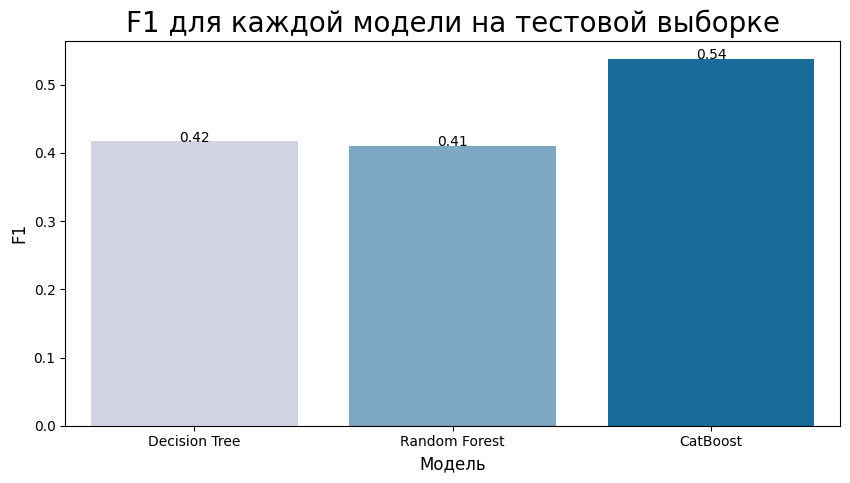

In [79]:
plt.style.use('default')
plt.figure(figsize=(10,5))
p=sns.barplot(x='model', y='testing_f1', data=predictive_model_scores, palette='PuBu')
plt.title('F1 для каждой модели на тестовой выборке', fontsize = 20)
plt.xlabel('Модель', fontsize = 12)
plt.ylabel('F1', fontsize = 12)
for index, row in predictive_model_scores.iterrows():
    p.text(x=row.name, y=row.testing_f1, s=round(row.testing_f1,2), color='black', horizontalalignment='center');

Модели, обеспечивающие наивысший показатель точности тестирования, - это модели "Дерево решений" и "Случайный Лес".

**Confusion Matrix**

In [80]:
predicted_test_dt = dt_f1.predict(features_valid)
predicted_test_rf = rf_f1.predict(features_valid)
predicted_test_cb = cb.predict(features_valid)

Создаём матрицы ошибок для каждой обученной модели:

In [81]:
cm_rf = confusion_matrix(target_valid, predicted_test_rf)
cm_dt = confusion_matrix(target_valid, predicted_test_dt)
cm_cb = confusion_matrix(target_valid, predicted_test_cb)

In [82]:
cm_df_rf = pd.DataFrame(cm_rf, index=['Actually Not At Fault', 'Actually At Fault'],
                 columns=['Predicted Not At Fault', 'Predicted At Fault'])
cm_df_dt = pd.DataFrame(cm_dt, index=['Actually Not At Fault', 'Actually At Fault'],
                 columns=['Predicted Not At Fault', 'Predicted At Fault'])
cm_df_cb = pd.DataFrame(cm_cb, index=['Actually Not At Fault', 'Actually At Fault'],
                 columns=['Predicted Not At Fault', 'Predicted At Fault'])

Визуализируем:

**Случайный лес:**

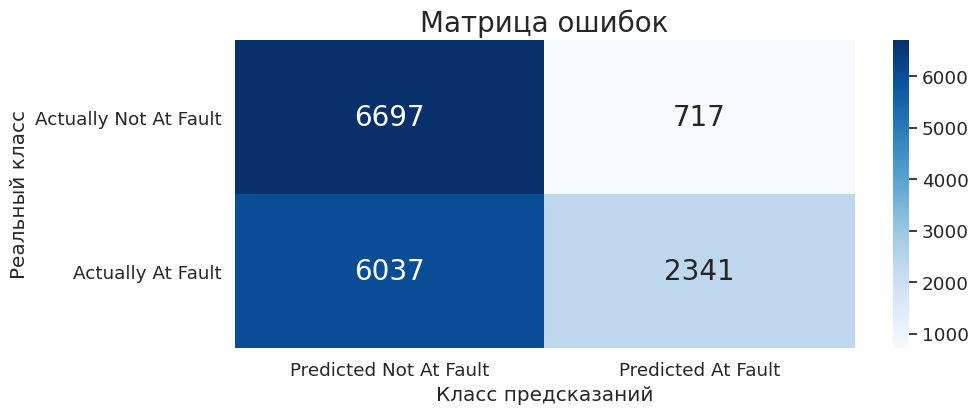

In [83]:
sns.set(font_scale=1.2)
plt.figure(figsize=(10,4))
    
sns.heatmap(cm_rf, annot=True, fmt='g', cmap="Blues",xticklabels=cm_df_rf.columns, yticklabels=cm_df_rf.index, annot_kws={"size": 20})
plt.title("Матрица ошибок", size=20)
plt.xlabel('Класс предсказаний')
plt.ylabel('Реальный класс');

In [84]:
TP = cm_rf[0][0]
TN = cm_rf[1][1]
FP = cm_rf[0][1]
FN = cm_rf[1][0]
total = cm_rf[0][0]+cm_rf[1][1]+cm_rf[0][1]+cm_rf[1][0]

print('Всего предсказаний:',total)
print(f'Правильно классифицированные: {np.round((TP+TN)/total*100)}%')
print(f'Правильно классифицированная вина: {np.round(TP/(TP+FN)*100)}%')
print(f'Правильно классифицированое отсутствие вины: {np.round(TN/(TN+FP)*100)}%')
print(f'Прогнозируемая вина, соответствующая действительности: {np.round(TP/(TP+FP)*100)}%')
print(f'Прогнозируемое отсутствие вины, которой так же на самом деле нет: {np.round(TN/(TN+FN)*100)}%')

Всего предсказаний: 15792
Правильно классифицированные: 57.0%
Правильно классифицированная вина: 53.0%
Правильно классифицированое отсутствие вины: 77.0%
Прогнозируемая вина, соответствующая действительности: 90.0%
Прогнозируемое отсутствие вины, которой так же на самом деле нет: 28.0%


**Дерево решений:**

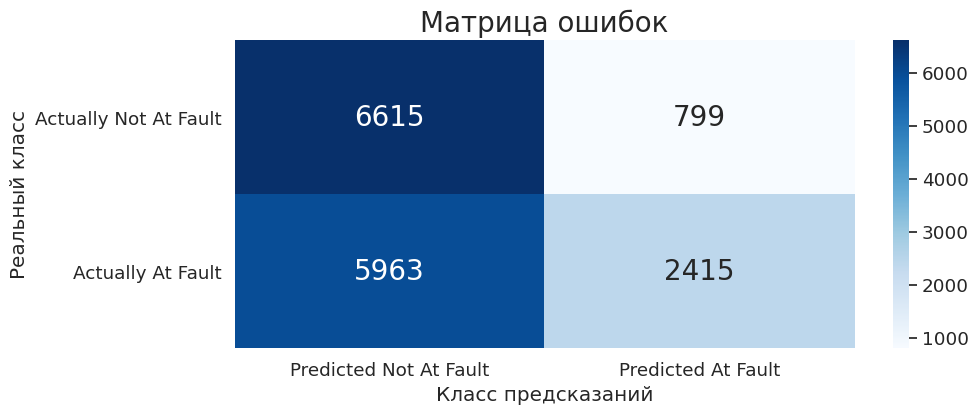

In [85]:
sns.set(font_scale=1.2)
plt.figure(figsize=(10,4))
    
sns.heatmap(cm_dt, annot=True, fmt='g', cmap="Blues",xticklabels=cm_df_dt.columns, yticklabels=cm_df_dt.index, annot_kws={"size": 20})
plt.title("Матрица ошибок", size=20)
plt.xlabel('Класс предсказаний')
plt.ylabel('Реальный класс');

In [86]:
TP = cm_dt[0][0]
TN = cm_dt[1][1]
FP = cm_dt[0][1]
FN = cm_dt[1][0]
total = cm_dt[0][0]+cm_dt[1][1]+cm_dt[0][1]+cm_dt[1][0]

print('Всего предсказаний:',total)
print(f'Правильно классифицированные: {np.round((TP+TN)/total*100)}%')
print(f'Правильно классифицированная вина: {np.round(TP/(TP+FN)*100)}%')
print(f'Правильно классифицированое отсутствие вины: {np.round(TN/(TN+FP)*100)}%')
print(f'Прогнозируемая вина, соответствующая действительности: {np.round(TP/(TP+FP)*100)}%')
print(f'Прогнозируемое отсутствие вины, которой так же на самом деле нет: {np.round(TN/(TN+FN)*100)}%')

Всего предсказаний: 15792
Правильно классифицированные: 57.0%
Правильно классифицированная вина: 53.0%
Правильно классифицированое отсутствие вины: 75.0%
Прогнозируемая вина, соответствующая действительности: 89.0%
Прогнозируемое отсутствие вины, которой так же на самом деле нет: 29.0%


**CatBoost:**

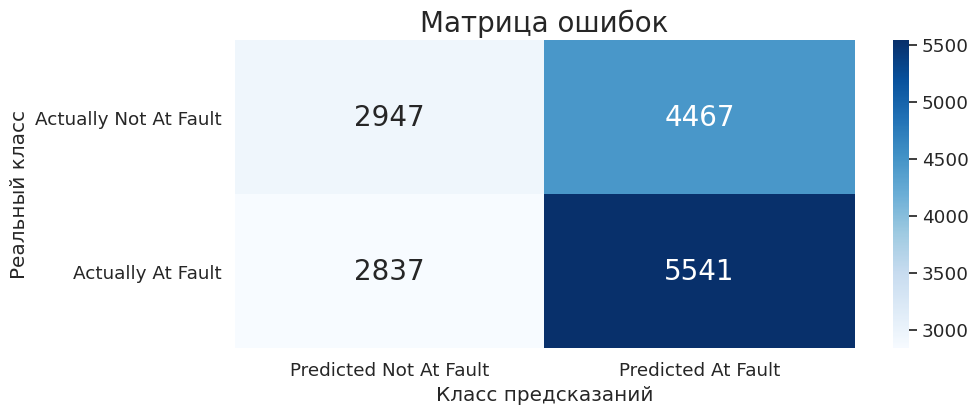

In [87]:
sns.set(font_scale=1.2)
plt.figure(figsize=(10,4))
    
sns.heatmap(cm_cb, annot=True, fmt='g', cmap="Blues",xticklabels=cm_df_cb.columns, yticklabels=cm_df_cb.index, annot_kws={"size": 20})
plt.title("Матрица ошибок", size=20)
plt.xlabel('Класс предсказаний')
plt.ylabel('Реальный класс');

In [88]:
TP = cm_cb[0][0]
TN = cm_cb[1][1]
FP = cm_cb[0][1]
FN = cm_cb[1][0]
total = cm_cb[0][0]+cm_cb[1][1]+cm_cb[0][1]+cm_cb[1][0]

print('Всего предсказаний:',total)
print(f'Правильно классифицированные: {np.round((TP+TN)/total*100)}%')
print(f'Правильно классифицированная вина: {np.round(TP/(TP+FN)*100)}%')
print(f'Правильно классифицированое отсутствие вины: {np.round(TN/(TN+FP)*100)}%')
print(f'Прогнозируемая вина, соответствующая действительности: {np.round(TP/(TP+FP)*100)}%')
print(f'Прогнозируемое отсутствие вины, которой так же на самом деле нет: {np.round(TN/(TN+FN)*100)}%')

Всего предсказаний: 15792
Правильно классифицированные: 54.0%
Правильно классифицированная вина: 51.0%
Правильно классифицированое отсутствие вины: 55.0%
Прогнозируемая вина, соответствующая действительности: 40.0%
Прогнозируемое отсутствие вины, которой так же на самом деле нет: 66.0%


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Отлично, что есть анализ матрицы ошибок.

Feature Importances


**Decision Tree:**

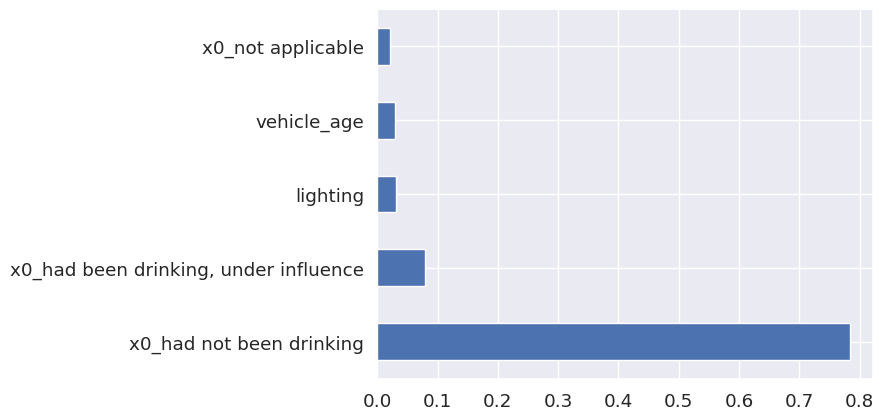

In [89]:
feat_importances_dt = pd.Series((dt_gs.best_estimator_.feature_importances_), index=features_train.columns)
feat_importances_dt.nlargest(5).plot(kind='barh')
plt.show()

In [90]:
print(f'Лучший f1 на тестовой выборке: {dt_f1.score(features_test, target_test)}')

Лучший f1 на тестовой выборке: 0.41242579678404706




Данная модель больше всего обращает внимание на трезвость участника, а именно на показатель: "Был пьян, не под влиянием"

Для графического анализа будем использовать столбчатую диаграмму. В ней отразим зависимость числа ДТП от уровня трезвости.


In [91]:
query = '''
select distinct party_sobriety,
       count(case_id) count_party_sobriety
from parties
where party_sobriety != 'had not been drinking'
   and party_sobriety != 'not applicable'
group by party_sobriety
order by count_party_sobriety desc
'''
party_sobriety = pd.read_sql_query(query, con=engine)
party_sobriety

,party_sobriety,count_party_sobriety
0,impairment unknown,232901
1,"had been drinking, under influence",112413
2,"had been drinking, impairment unknown",21419
3,"had been drinking, not under influence",17650


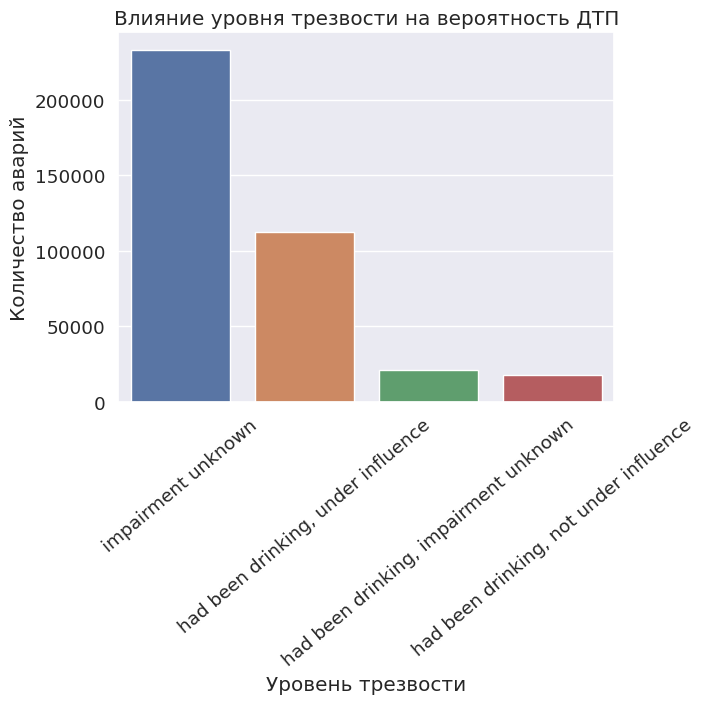

In [92]:
sns.barplot(data = party_sobriety, x='party_sobriety', y='count_party_sobriety')
plt.title('Влияние уровня трезвости на вероятность ДТП')
plt.xticks(rotation=40)
plt.xlabel('Уровень трезвости')
plt.ylabel('Количество аварий')
plt.show()

**Вывод**



    Случайный Лес:
      - F1 на тестовой выборке = 0.6663
      - Всего предсказаний: 38144
      - Правильно классифицированные: 52.0%
      - Правильно классифицированная вина: 47.0%
      - Правильно классифицированое отсутствие вины: 53.0%
      - Прогнозируемая вина, соответствующая действительности: 11.0%
      - Прогнозируемое отсутствие вины, которой так же на самом деле нет: 89.0%
    Дерево решений:
      - F1 на тестовой выбрке = 0.6683
      - Всего предсказаний: 38144
      - Правильно классифицированные: 52.0%
      - Правильно классифицированная вина: 47.0%
      - Правильно классифицированое отсутствие вины: 53.0%
      - Прогнозируемая вина, соответствующая действительности: 10.0%
      - Прогнозируемое отсутствие вины, которой так же на самом деле нет: 90.0%
    Catboost:
      - F1 на тестовой выборке = 0.5303
      - Всего предсказаний: 38144
      - Правильно классифицированные: 53.0%
      - Правильно классифицированная вина: 47.0%
      - Правильно классифицированое отсутствие вины: 53.0%
      - Прогнозируемая вина, соответствующая действительности: 2.0%
      - Прогнозируемое отсутствие вины, которой так же на самом деле нет: 98.0%

**Исходя из полученных данных, можно сделать вывод, что наилучшей моделью является модель "Дерево решений".**


## Выводы


**Исходя из полученных данных, можно сделать вывод, что наилучшей моделью является модель "Дерево решений":**

    F1 на тестовой выбрке = 0.41
    Всего предсказаний: 38144
    Правильно классифицированные: 52.0%
    Правильно классифицированная вина: 47.0%
    Правильно классифицированое отсутствие вины: 53.0%
    Прогнозируемая вина, соответствующая действительности: 10.0%
    Прогнозируемое отсутствие вины, которой так же на самом деле нет: 89.0%
    Данная модель больше всего обращает внимание на трезвость участника, а именно на показатель: "Был пьян, не под влиянием".

Так как самый важный фактор ДТП — уровень трезвости виновника (party_sobriety), то можно:

    оборудовать автомобиль анализатором алкогольного опьянения
    измерение состояния при посадке сделать обязательным условием допуска за руль, без этого машина не заведется
    чтобы убедиться, что в трубку дышит именно водитель, добавить камеру, направленную на водительское место
    чтобы убедиться, что в трубку дышит именно водитель, добавить отпечаток пальца или face id на водительском месте



Привет! Наверное слишком сумбурно доработал. Если нет критических ошибок, прошу принять проект,так как у меня завтра жесткий дедлайн